# Gas Streaming in Disks: orbit approach

The gas streaming around a young star, or in a galactic disk is dominated by gravity. So we can simply compute the orbits of a point mass around a star, or in the more complex potential of a galactic disk. Although there is a wonderful package in python for this, [galpy](https://github.com/jobovy/galpy), we will first try and use this from scratch in simple pure python. Another more advanced package using the C language, [NEMO](http://www.astro.umd.edu/nemo), also has programs to achieve the same result.

In [115]:
# python 2-3 compatibility
from __future__ import print_function

In [116]:
%matplotlib inline

# Initialize the data

In [117]:
import numpy as np
import math

First we need to define a helper function that tells us the speed of the gas at a given distance from the center of the star or galaxy. We consider 4 simple cases here. Recall from your basic Newtonian physics that the circular speed of a test particle around a mass balances gravity and centrifugal force:
$$
  {v^2 \over r} = { G M(<r) \over {r^2}}
$$
from which we derive the rotation curve , $v(r)$:
$$
   { v(r) } = \sqrt{  { G M(<r) \over r }}
$$
Alternatively, if we know a rotation curve, we know how the cumulative mass, $M(<r)$ increases:
$$
    M(<r) = {    { v^2 r } \over G }
$$
all assuming the mass is spherically distributed, which isn't quite true. A geometric correction factor would be needed for this.

In [118]:
def velocity(radius, model='galaxy'):
    """describe the streaming velocity as function of radius in or around an object
    such as a star or a galaxy.  We define the velocity to be 1 at a radius of 1.
    
    Caveat: radius is a scalar. It would be convenient if it could also be an array
    and the function then return an array of velocities. This can be easily done in
    python, but left out to keep the code simple.
    """
    if model == 'star':
        # A star has a keplerian rotation curve. The planets around our sun obey this law.
        if radius == 0.0:
            return 0.0
        else:
            return 1.0/math.sqrt(radius)
    elif model == 'galaxy':
        # Most disk galaxies have a flat rotation curve with a linear slope in the center.
        if radius > 1.0:
            # flat rotation curve outside radius 1.0
            return 1.0
        else:
            # solid body inside radius 1.0, linearly rising rotation curve
            return radius
    elif model == 'sphere':
        # a (solid) sphere with radius 1 and mass 1
        if radius < 1.0:
            return radius
        else:
            return 1.0/math.sqrt(radius) 
    elif model == 'plummer':
        # A plummer sphere was an early 1800s description of clusters, and is not
        # a bad description for the inner portions of a galaxy. You can also view it
        # as a hybrid and softened version of the 'star' and 'galaxy' described above.
        # Note: not 1 at 1 yet
        return  radius / (1+radius*radius)**0.75
    else:
        return 0.0
        

In [119]:
#model = 'star'
#model = 'galaxy'
model = 'plummer'
#model = 'sphere'
rad = np.arange(0.0,4.0,0.05)
vel = rad * 0.0                         # vel = velocity(rad,model)    is not implemented in this code
for i in range(len(rad)):
    vel[i] = velocity(rad[i],model)

## Plotting the Rotation Curve

In [120]:
import matplotlib.pyplot as plt

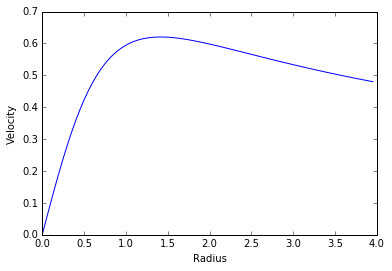

In [121]:
plt.plot(rad,vel)
plt.xlabel("Radius")
plt.ylabel("Velocity")

This curve of velocity as function of radius is called a **Rotation Curve**, and extracting such a curve from an observation is crucial to understanding the mass distribution within a galaxy, or the mass of the old stars at the center of the disk. We are assuming the gas is on circular orbits, which turns out is not always exactly correct. For this experiment we will keep that assumption. In real galaxies we have interactions, warps, spiral arms, bars etc.

In [122]:
inc = 60                                # inclination of the disk (0 means face-on, 90 means edge-on)
cosi = math.cos(inc*math.pi/180.0)      # convenience
sini = math.sin(inc*math.pi/180.0)
r0 = 4.0                                #  radius of the disk
dr = 0.5                                #  steps in radii

## Forward projection

This is the most simple generic method. You describe the model, project it and simply compute the observables (the observed position **x** and **y**, and the radial velocity **v**). You then need to grid these observed points on a sky grid, and apply the kind of smoothing a real telescope will do.


In [123]:
# get random points along a regular series of circles, which describes the model
# we assume the gas is streaming along those circles
radii = np.arange(dr,r0,dr)   # create array of radii of where rings are
xobs = np.arange(0)           # create dummy arrays, so we can append to them
yobs = np.arange(0)
vobs = np.arange(0)
nppr = 45                     # number of points per ring
for r in radii:               # loop over the rings, adding points for each ring
    vrot = velocity(r,model)
    phi = np.random.random(nppr)*2*math.pi
    # orbit properties we need
    x  = r*np.cos(phi)
    y  = r*np.sin(phi)
    v  = vrot*np.cos(phi)
    # project
    xobs  = np.append(xobs,x)
    yobs  = np.append(yobs,y*cosi)
    vobs  = np.append(vobs,v*sini)
print("Total number of points:",vobs.shape[0])

Total number of points: 315


Now we have a set of (xobs,yobs,vobs) points that need to be gridded on the sky.

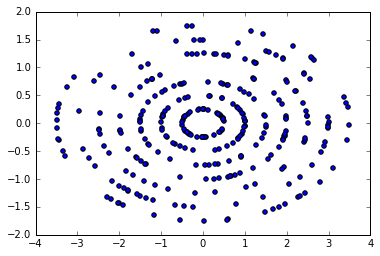

In [124]:
plt.scatter(xobs,yobs)

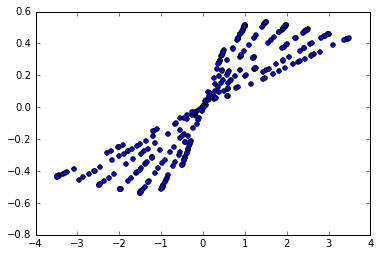

In [125]:
plt.scatter(xobs,vobs)

In [126]:
import scipy.interpolate


In [127]:
# f = scipy.interpolate.interp2d(xobs,yobs, vobs)

Perhaps you can already see some flaws in this approach. But it's a more general approach to simulate an observation.  We will now do the reverse operation, since the rotation disk is simple to describe, and arguably easier to understand.

## Backwards Projection

This is where we take a point in the sky, and deproject back where in the galaxy this point came from and compute the velocity and projected velocity. The advantage is the simplicity of computing the observable at each picked point in the sky. The drawback is that the deprojection may not be trivial in cases where the model is not simple, e.g. non-circular motion and/or non-planar disks. It also does not take into account that neighboring points should be averaged in a proper way to account for the fact that telescopes don't have infinite resolution. In the forwards projection method this is easier to deal with as one of the natural steps of that type of simulation of the observation.


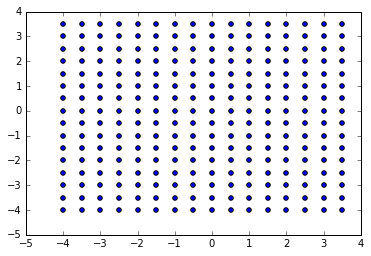

In [128]:
dr = 0.5                         # grid size
x = np.arange(-r0,r0,dr)
y = np.arange(-r0,r0,dr)
xx,yy = np.meshgrid(x,y)
rr = np.sqrt(xx*xx+(yy/cosi)**2)
if r0/dr < 20:                    # only plot if we don't have too many trees in the forest
    plt.scatter(xx,yy)
else:
    print("Skipping plot")

Although we have defined a function **velocity** to compute the rotation velocity at any radius, this function cannot easily compute from a numpy array, as we just created on a grid on the sky. Thus we need a convenience function to do just that, which we'll call **velocity2d**:

In [129]:
def velocity2d(rad2d, model):
    """ convenience function to take a 2d array of radii
        and return the same-shaped velocities
    """
    (ny,nx) = rad2d.shape
    vel2d = rad2d.copy()
    for y in range(ny):
        for x in range(nx):
            vel2d[y,x] = velocity(rad2d[y,x],model)
    return vel2d

In [130]:
vv = velocity2d(rr,model)
vvmasked = np.ma.masked_where(rr>r0,vv)
vobs = vvmasked * xx / rr * sini


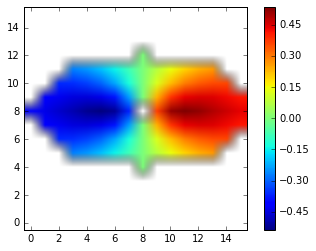

In [131]:
plt.imshow(vobs,origin=['Lower'])
plt.colorbar()

This plot will not look very good if you don't make the step size in radius (**dr**) small enough.